# Forecast weekly gross for Majestic Theatre using SARIMAX

For the non-exogenous parameters of the SARIMAX model, we use the values (2,0,1)x(1,0,1,52) that has been used for the SARIMA model. We choose 'avg_ticket_price' and 'possible_gross' as the exogenous variables.


## Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pmdarima as pm

from pathlib import Path
from pylab import rcParams
from itertools import product

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse # Root Mean Square Error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

## Notebook Settings

In [2]:
warnings.filterwarnings("ignore")  # hide warnings

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 10]

## Useful Functions

In [3]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
    ax = train.loc[start:].plot(style='-')
    test.plot(ax=ax, style='--')
    forecast.plot(ax=ax)
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.savefig('new_fig.png')
    plt.show()

## Get the Data

In [4]:
filepath = 'grosses.csv'
data = pd.read_csv(filepath,
                 header=0,
                 parse_dates=['week_ending'],
                 index_col=0,
                 usecols=['week_ending','theatre','weekly_gross'])
data_e = pd.read_csv(filepath,
                 header=0,
                 parse_dates=['week_ending'],
                 index_col=0,
                 usecols=['week_ending','theatre','weekly_gross','avg_ticket_price','potential_gross'])

In [5]:
majestic_df = data[(data['theatre'] == 'Majestic Theatre')]

In [6]:
majestic_df_e = data_e[(data_e['theatre'] == 'Majestic Theatre')]

In [7]:
majestic_df.drop(['theatre'], axis=1, inplace = True) 

In [8]:
majestic_df_e.drop(['theatre'], axis=1, inplace = True) 

In [9]:
### We will use data for majestic Theatre from 2013-06-02 to 2019-05-26.
start_date = '2013-06-02'
#end_date = '2018-05-27'
end_date = '2019-05-26'
majestic_df = majestic_df.loc[start_date : end_date]
majestic_df = majestic_df.asfreq('W')
majestic_df.head(1)
majestic_df_e = majestic_df_e.loc[start_date : end_date]
majestic_df_e = majestic_df_e.asfreq('W')
majestic_df_e.head(1)

,weekly_gross,potential_gross,avg_ticket_price
week_ending,,,
2013-06-02,1100715.0,1365763.0,87.6


In [10]:
majestic_df_e[majestic_df_e['weekly_gross'].isna()]

,weekly_gross,potential_gross,avg_ticket_price
week_ending,,,
2015-12-27,NaN,NaN,NaN


In [11]:
majestic_df = majestic_df.fillna(method='ffill')
majestic_df_e = majestic_df_e.fillna(method='ffill')

In [12]:
y = majestic_df.weekly_gross[261:]

In [13]:
model = pm.arima.ARIMA(order=(2,0,1),seasonal_order=(1,0,1,52),with_intercept=False)

In [14]:
model.fit(majestic_df.values[0:261],X = majestic_df_e[['avg_ticket_price','potential_gross']][0:261])

ARIMA(order=(2, 0, 1), seasonal_order=(1, 0, 1, 52), with_intercept=False)

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  261
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -3308.121
Date:                            Fri, 02 Jun 2023   AIC                           6632.242
Time:                                    21:12:10   BIC                           6660.758
Sample:                                06-02-2013   HQIC                          6643.705
                                     - 05-27-2018                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
avg_ticket_price  1.827e+04    751.207     24.318      0.000    1.68e+04    1.97e+04
potential_gross      0.4584      0.114      4.034      0.000       0.236       0.681
ar.L1                1.2887      0.121     10.680      0.000       1.052       1.525
ar.L2               -0.2893      0.121     -2.399      0.016      -0.526      -0.053
ma.L1               -0.8231      0.078    -10.567      0.000      -0.976      -0.670
ar.S.L52             0.7555      0.212      3.558      0.000       0.339       1.172
ma.S.L52            -0.4534      0.294     -1.543      0.123      -1.029       0.122
sigma2            8.671e+09      0.000   8.63e+13      0.000    8.67e+09    8.67e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.77   Prob(JB):                         0.32
Heteroskedasticity (H):               1.39   Skew:                             0.23
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.6e+29. Standard errors may be unstable.
"""

In [16]:
preds, conf_int = model.predict(n_periods=52, X=majestic_df_e[['avg_ticket_price','potential_gross']][261:], return_conf_int=True)

In [18]:
rmse(y,preds)

117535.18558310645

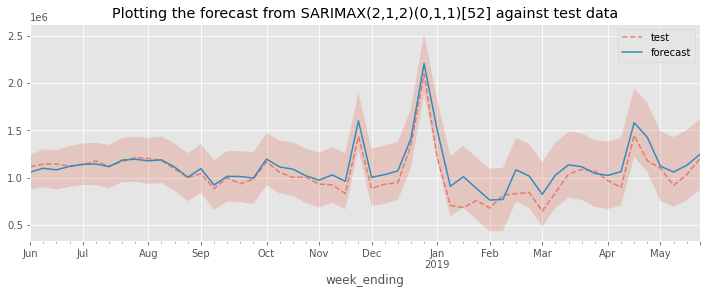

In [17]:
n = y.shape[0]
lower_ci, upper_ci  = zip(*conf_int)
index = y.index
ax = y.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(preds, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast'])
plt.title("Plotting the forecast from SARIMAX(2,1,2)(0,1,1)[52] against test data")
plt.savefig("with_external.png")
plt.show()